In [112]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [114]:
len(words)

32033

In [115]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [116]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [117]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [118]:
X[:6,]

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0]])

In [119]:
Y[:6]

tensor([ 5, 13, 13,  1,  0, 15])

In [120]:
g = torch.Generator().manual_seed(2147483647+2)
C = torch.randn((27, 2), generator=g)

In [121]:
C[:6,]

tensor([[-0.6839,  0.0283],
        [ 0.7678, -0.4540],
        [-0.9346,  0.6324],
        [ 0.4164, -1.0378],
        [ 0.5803, -2.5756],
        [-0.5588,  0.9751]])

In [122]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [123]:
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)

In [124]:
# we want emb to be 32 by 6, the six being 2 by 3 first layer neurons
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

torch.Size([32, 6])

In [125]:
# to cope with any block_size
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [126]:
# more efficiently, as all torch tensors are stored as one-dimensional
# emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

In [127]:
xDim0 = X.shape[0]
h = torch.zeros((xDim0, 100))
for i in range(xDim0):
    h[i] = emb.view(-1, 6)[i,:] @ W1 + b1
#     print(h[i])
print('h.min =',torch.min(h), 'h.max =',torch.max(h))

h.min = tensor(-10.3292) h.max = tensor(9.9944)


In [128]:
print(h.shape, h.dtype)

torch.Size([32, 100]) torch.float32


In [129]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)
print(W2.shape, W2.dtype)

torch.Size([100, 27]) torch.float32


In [130]:
# logits = h[:,:29] @ W2[:29,:]
logits = h @ W2 + b2
logits /= 10

In [131]:
print(logits.shape, logits.dtype)
print('logits.max =', torch.max(logits), 'logits.min =', torch.min(logits))

torch.Size([32, 27]) torch.float32
logits.max = tensor(10.2566) logits.min = tensor(-10.1803)


In [132]:
counts = logits.exp()
print('min(counts) =', torch.min(counts), 'max(counts) =', torch.max(counts))

min(counts) = tensor(3.7911e-05) max(counts) = tensor(28470.3242)


In [133]:
prob = counts / counts.sum(1, keepdims=True)
torch.min(prob)

tensor(1.0569e-09)

In [134]:
print(prob.shape)
prob.sum(1)
print(prob)

torch.Size([32, 27])
tensor([[3.1552e-02, 2.4393e-03, 4.2834e-03, 1.6376e-02, 8.2613e-03, 2.6035e-02,
         1.9344e-01, 1.6046e-03, 2.1348e-03, 4.5758e-04, 1.5580e-02, 8.7492e-03,
         5.2642e-02, 1.6860e-02, 4.7842e-02, 2.8344e-02, 4.2917e-03, 3.5706e-02,
         7.2150e-02, 1.0739e-02, 3.7249e-03, 5.6564e-02, 2.7348e-01, 7.2411e-02,
         4.4776e-03, 1.2730e-03, 8.5790e-03],
        [3.0890e-02, 6.1272e-03, 1.4810e-03, 1.0848e-02, 1.5643e-02, 3.2987e-02,
         2.5105e-01, 7.2413e-04, 3.0510e-03, 2.9452e-04, 6.3125e-03, 1.4149e-02,
         2.6792e-02, 7.5271e-03, 4.5408e-02, 3.1688e-02, 4.1022e-03, 5.3731e-02,
         1.0192e-01, 8.1777e-03, 1.5669e-03, 1.5288e-01, 1.6022e-01, 2.0172e-02,
         3.5893e-03, 5.5972e-03, 3.0700e-03],
        [1.8234e-02, 1.0934e-03, 4.9068e-04, 3.4447e-02, 3.0642e-03, 1.9169e-02,
         5.1444e-01, 4.1764e-04, 1.2194e-03, 4.3955e-04, 3.7714e-03, 2.9515e-03,
         2.1857e-02, 6.3003e-03, 1.0162e-02, 4.5842e-03, 1.1559e-02, 1.7725e-

In [135]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(6.3009)

In [136]:
# ----------------- now made respectable :) -------------------

In [137]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
# for w in words[:5]:
for w in words:
    
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [138]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [139]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = (C, W1, b1, W2, b2)
for p in parameters:
    p.requires_grad = True

In [140]:
sum(p.nelement() for p in parameters)

3481

In [160]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [170]:
lri = []
lossi = []

for i in range(1000):
    
    #construct minibatch
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] 
    XDim0 = X.shape[0]
    XDim0 = 32
    h = torch.zeros((XDim0, 100))
    for j in range(XDim0):
        h[j] = torch.tanh(emb.view(-1, 6)[j,:] @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = lrs[i].item()
    for p in parameters:
        p.data += -lr * p.grad
        
    #track stats
    lri.append(lre[i])
    lossi.append(loss.item())
        
print(loss.item())


3.610029935836792


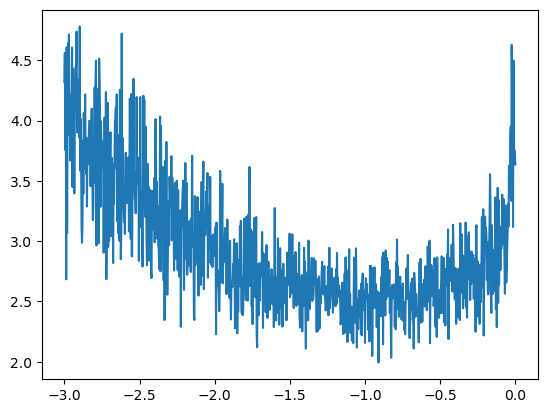

In [169]:
plt.plot(lri, lossi)

In [171]:
    emb = C[X] 
    XDim0 = X.shape[0]
    h = torch.zeros((XDim0, 100))
    for i in range(XDim0):
        h[i] = torch.tanh(emb.view(-1, 6)[i,:] @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

3.3726906776428223


In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = (C, W1, b1, W2, b2)
for p in parameters:
    p.requires_grad = True